In [1]:
## Python packages - you may have to pip install sqlalchemy, sqlalchemy_utils, and psycopg2. See below for troubleshooting.
from sqlalchemy import create_engine
# from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
from pandas import pivot_table
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc, roc_curve, make_scorer
import seaborn as sns

In [2]:
#In Python: Define a database name, and your username for your computer (CHANGE IT BELOW). 
dbname = 'wespire_app_data'
username = 'xixibest'

#create_db wespire_app_data

## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

# Read in the csv file.
# campaign_user_score = pd.DataFrame.from_csv('Raw/campaign_user_scores.csv')
# print('done!')

# Do the querries in Python
# connect:
con = None
con = psycopg2.connect(database = dbname, user = username)

postgres://xixibest@localhost/wespire_app_data


In [3]:
sql_query = """
SELECT scores.id, points,
  scores.user_id,
  scores.scorable_id,
  scores.created_at,
  categories.name_reporting
FROM scores
LEFT JOIN classifications ON classifications.categorizable_type = 'Act'
AND classifications.categorizable_id = scores.scorable_id
LEFT JOIN categories ON categories.id = classifications.category_id
WHERE scorable_type = 'Act' AND scores.created_at >= '2017-03-01' AND scores.created_at <= '2017-04-30'
"""
user_Act = pd.read_sql_query(sql_query,con)
print('done')

done


In [4]:
user_Act.head()
user_Act['dummy']=1
user_Act.sort_values(by='user_id').head(n=15)
user_Act.name_reporting[pd.isnull(user_Act['name_reporting'])]='None'
user_Act.head()

/Users/xixibest/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,id,points,user_id,scorable_id,created_at,name_reporting,dummy
0,8296469,5,113414,2066,2017-03-01 00:00:01.708791,Volunteering,1
1,8296469,5,113414,2066,2017-03-01 00:00:01.708791,Giving,1
2,8296470,2,61317,13527,2017-03-01 00:00:05.067060,None,1
3,8296471,20,61317,13513,2017-03-01 00:00:10.388790,Sustainable Consumption,1
4,8296471,20,61317,13513,2017-03-01 00:00:10.388790,Reduce,1


In [5]:
table = pivot_table(user_Act, values='dummy', index=['user_id'],
                   columns=['name_reporting'], aggfunc=np.sum, margins=True)
table.fillna(value=0,inplace=True)
table=pd.DataFrame(table)
table['user_id'] = table.index
table.sort_values(by='user_id').head()
table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5953 entries, 144 to All
Data columns (total 20 columns):
Enjoy                      5953 non-null float64
Food                       5953 non-null float64
Giving                     5953 non-null float64
HR                         5953 non-null float64
Health & Wellness          5953 non-null float64
Home Improvement           5953 non-null float64
How to use WeSpire         5953 non-null float64
Learn                      5953 non-null float64
None                       5953 non-null float64
Office                     5953 non-null float64
Recycle                    5953 non-null float64
Reduce                     5953 non-null float64
Reuse                      5953 non-null float64
Social                     5953 non-null float64
Society                    5953 non-null float64
Sustainable Consumption    5953 non-null float64
Transportation             5953 non-null float64
Volunteering               5953 non-null float64
All            

In [6]:
user_login = pd.read_csv('user_login.csv',index_col=False)
del user_login['user_id.1']

baduser = pd.read_csv('baduser.csv')
baduser.drop('Unnamed: 0', axis = 1, inplace=True)

user = pd.DataFrame()
user = user_login.merge(table, how = 'left', on = 'user_id')
user.fillna(0,inplace=True)
user_good = user[~(user.user_id.isin(baduser.user_id))]
user_good['active']=np.where(user_good.num_of_login >=9, 1, 0)
user_good.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5598 entries, 0 to 5621
Data columns (total 22 columns):
user_id                    5598 non-null int64
num_of_login               5598 non-null int64
Enjoy                      5598 non-null float64
Food                       5598 non-null float64
Giving                     5598 non-null float64
HR                         5598 non-null float64
Health & Wellness          5598 non-null float64
Home Improvement           5598 non-null float64
How to use WeSpire         5598 non-null float64
Learn                      5598 non-null float64
None                       5598 non-null float64
Office                     5598 non-null float64
Recycle                    5598 non-null float64
Reduce                     5598 non-null float64
Reuse                      5598 non-null float64
Social                     5598 non-null float64
Society                    5598 non-null float64
Sustainable Consumption    5598 non-null float64
Transportation 

/Users/xixibest/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
user.head()

,user_id,num_of_login,Enjoy,Food,Giving,HR,Health & Wellness,Home Improvement,How to use WeSpire,Learn,...,Office,Recycle,Reduce,Reuse,Social,Society,Sustainable Consumption,Transportation,Volunteering,All
0,144,21,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,16.0
1,6148,17,1.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,...,3.0,0.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,23.0
2,6172,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
3,16393,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,19681,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
print (user_good == 0).sum(0)/len(user_good)

user_id                    0.000000
num_of_login               0.000000
Enjoy                      0.941050
Food                       0.879600
Giving                     0.944444
HR                         0.981958
Health & Wellness          0.836013
Home Improvement           0.858700
How to use WeSpire         0.987853
Learn                      0.943730
None                       0.458557
Office                     0.929618
Recycle                    0.975884
Reduce                     0.829225
Reuse                      0.834762
Social                     0.899250
Society                    0.973741
Sustainable Consumption    0.902822
Transportation             0.981958
Volunteering               0.949982
All                        0.426938
active                     0.895498
dtype: float64


In [8]:
#Remove the users who does not have any actions
user_good_2 = user_good[~(user_good.All==0)]
user_good_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3208 entries, 0 to 5620
Data columns (total 22 columns):
user_id                    3208 non-null int64
num_of_login               3208 non-null int64
Enjoy                      3208 non-null float64
Food                       3208 non-null float64
Giving                     3208 non-null float64
HR                         3208 non-null float64
Health & Wellness          3208 non-null float64
Home Improvement           3208 non-null float64
How to use WeSpire         3208 non-null float64
Learn                      3208 non-null float64
None                       3208 non-null float64
Office                     3208 non-null float64
Recycle                    3208 non-null float64
Reduce                     3208 non-null float64
Reuse                      3208 non-null float64
Social                     3208 non-null float64
Society                    3208 non-null float64
Sustainable Consumption    3208 non-null float64
Transportation 

In [9]:
user_good_2.num_of_login.quantile([0.5,0.75,0.85,0.90])

0.50     3.0
0.75     6.0
0.85     9.0
0.90    12.0
Name: num_of_login, dtype: float64

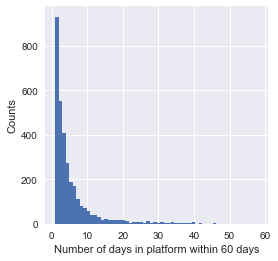

In [10]:
ax = user_good_2.num_of_login.hist(bins=max(user_good_2.num_of_login),figsize=(4,4))
ax.set_xlabel('Number of days in platform within 60 days')
ax.set_ylabel('Counts')

In [12]:
user_good_2.num_of_login.quantile([0.75,0.85])

0.75    6.0
0.85    9.0
Name: num_of_login, dtype: float64

In [13]:
user_good_2.max()

user_id                    140774.0
num_of_login                   58.0
Enjoy                         156.0
Food                          342.0
Giving                         55.0
HR                             75.0
Health & Wellness             685.0
Home Improvement              662.0
How to use WeSpire             19.0
Learn                         190.0
None                         2628.0
Office                        206.0
Recycle                       128.0
Reduce                       1027.0
Reuse                         906.0
Social                        555.0
Society                        84.0
Sustainable Consumption       208.0
Transportation                 36.0
Volunteering                   72.0
All                          5464.0
active                          1.0
dtype: float64

In [68]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.embed import components
from bokeh.models import FactorRange
from bokeh.models import ColumnDataSource
from math import pi

tmp = user_good_2[user_good_2.user_id==144]
tmp.sort_values(by='num_of_login')
tmp2=tmp.drop(['user_id','num_of_login','All','active'],axis=1)
# tmp2 =tmp2.transpose()

# ax=tmp2.plot(kind="bar", label='Days of visits is')
# ax.set_xlabel('Type of Actions')
# ax.set_ylabel('Number of Actions')


# ax.legend(['Days of visit: %d' %tmp.num_of_login],loc='upper right', shadow=True, fontsize='x-large')
# plt.show()

#tmp2=tmp.drop(['user_id','num_of_login','All','active'],axis=1)
tmp2 =tmp2.transpose()
  

x_factors = list(tmp2.index)
y_values = tmp2.values.ravel()
df = pd.DataFrame(dict(x=x_factors, y=y_values))
df['h'] = df['y'] / 2
src = ColumnDataSource(df)

p = figure(x_range=x_factors, y_range=[min(y_values)-1, max(y_values)+1],   plot_width=500, plot_height=400, y_axis_label="Number of Actions")
p.circle(x='x', y='y',source=src, size=15 ,legend='Days of visits: %d'% int(tmp.num_of_login.values))
p.segment(x_factors, 0, x_factors, y_values, line_width=2, line_color="green", )
p.xaxis.major_label_orientation = pi/4
show(p)

In [73]:
tmp = user_good_2
tmp.sort_values(by='num_of_login', ascending=False,inplace=True)
tmp

/Users/xixibest/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,user_id,num_of_login,Enjoy,Food,Giving,HR,Health & Wellness,Home Improvement,How to use WeSpire,Learn,...,Recycle,Reduce,Reuse,Social,Society,Sustainable Consumption,Transportation,Volunteering,All,active
564,61228,58,2.0,29.0,1.0,0.0,178.0,123.0,1.0,23.0,...,0.0,208.0,178.0,8.0,2.0,8.0,1.0,9.0,2151.0,1
3831,116600,53,1.0,1.0,1.0,0.0,6.0,0.0,0.0,1.0,...,0.0,3.0,3.0,2.0,0.0,1.0,0.0,1.0,84.0,1
1367,83602,52,0.0,38.0,1.0,0.0,284.0,161.0,0.0,2.0,...,4.0,406.0,399.0,1.0,0.0,23.0,7.0,2.0,1570.0,1
981,72402,51,3.0,2.0,0.0,0.0,74.0,15.0,0.0,13.0,...,0.0,167.0,53.0,5.0,2.0,1.0,0.0,6.0,823.0,1
1660,92282,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1561.0,1
833,68963,49,0.0,189.0,0.0,0.0,373.0,100.0,0.0,0.0,...,0.0,331.0,331.0,47.0,0.0,24.0,0.0,0.0,1553.0,1
3710,115744,47,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2.0,3.0,3.0,7.0,0.0,0.0,0.0,0.0,19.0,1
1967,100917,46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1
5451,139638,46,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,560.0,1
4255,119981,44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1


In [36]:
tmp2.values.ravel()

array([ 0.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,  6.,  0.,  0.,  3.,  3.,
        0.,  0.,  0.,  0.,  0.])

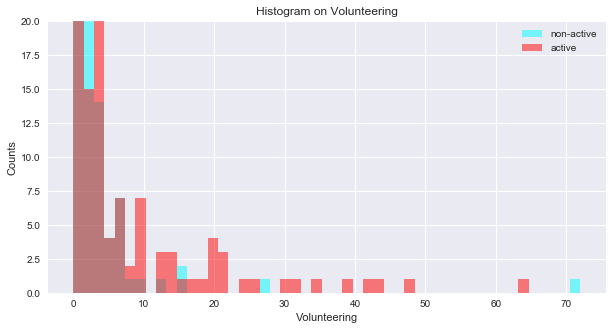

In [14]:
groups = user_good_2['active']
ix = (groups == 1)

bins = np.linspace(0, max(user_good_2.Volunteering),50)
fig, ax = plt.subplots(figsize = (10,5))
ax.hist(user_good_2[~ix]['Volunteering'],alpha = 0.5,color='cyan',bins=bins)
ax.hist(user_good_2[ix]['Volunteering'],alpha= 0.5,color = 'red',bins=bins)
ax.set(title='Histogram on Volunteering', ylabel='Counts')
ax.legend(['non-active','active'])
#ax.set_ylim(0,0.01)
ax.set_ylim(0,20)  
#ax.set_ylim(0, int(max(user_good[ix]['num_of_acts'])*1.0))
ax.set_xlabel('Volunteering')
ax.set_ylabel('Counts')
plt.show()

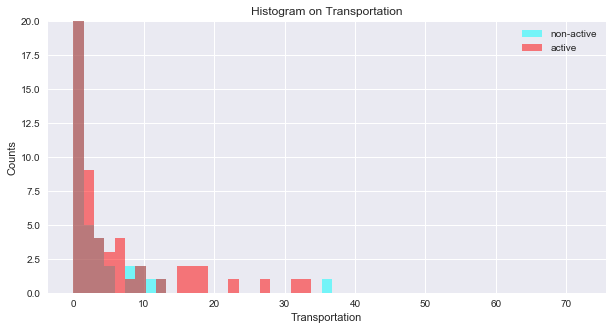

In [16]:
groups = user_good_2['active']
ix = (groups == 1)

bins = np.linspace(0, max(user_good_2.Volunteering),50)
fig, ax = plt.subplots(figsize = (10,5))
ax.hist(user_good_2[~ix]['Transportation'],alpha = 0.5,color='cyan',bins=bins)
ax.hist(user_good_2[ix]['Transportation'],alpha= 0.5,color = 'red',bins=bins)
ax.set(title='Histogram on Transportation', ylabel='Counts')
ax.legend(['non-active','active'])
#ax.set_ylim(0,0.01)
ax.set_ylim(0,20)  
#ax.set_ylim(0, int(max(user_good[ix]['num_of_acts'])*1.0))
ax.set_xlabel('Transportation')
ax.set_ylabel('Counts')
plt.show()

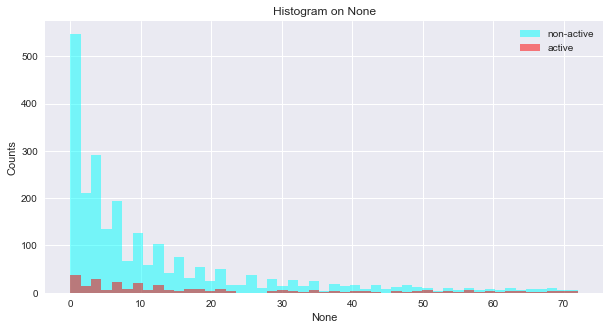

In [18]:
groups = user_good_2['active']
ix = (groups == 1)

bins = np.linspace(0, max(user_good_2.Volunteering),50)
fig, ax = plt.subplots(figsize = (10,5))
ax.hist(user_good_2[~ix]['None'],alpha = 0.5,color='cyan',bins=bins)
ax.hist(user_good_2[ix]['None'],alpha= 0.5,color = 'red',bins=bins)
ax.set(title='Histogram on None', ylabel='Counts')
ax.legend(['non-active','active'])
#ax.set_ylim(0,0.01)
#ax.set_ylim(0,100)  
#ax.set_ylim(0, int(max(user_good[ix]['num_of_acts'])*1.0))
ax.set_xlabel('None')
ax.set_ylabel('Counts')
plt.show()

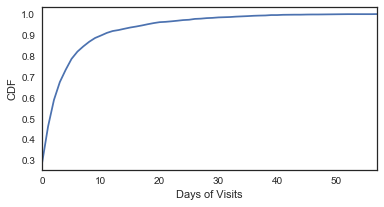

In [644]:
values, base = np.histogram(user_good_2.num_of_login,bins=user_good_2.num_of_login.max())
#evaluate the cumulative
cumulative = np.cumsum(values)
cumulative_norm = cumulative*1.0/cumulative[-1]
# plot the cumulative function
#plt.plot(base[:-1], cumulative, c='blue')
#plt.xlable 
#plt.show()

cumulative_norm=pd.DataFrame(cumulative_norm)
ax = cumulative_norm.plot(use_index=True,figsize=(6,3))

ax.set_xlabel('Days of Visits')
ax.set_ylabel('CDF')
ax.legend_.remove()

In [641]:
cumulative[-1]

3208

In [606]:
sum(user_good_2.num_of_login)

16514

In [576]:
print (user_good_2 == 0).sum(0)/len(user_good_2)

user_id                    0.000000
num_of_login               0.000000
Enjoy                      0.897132
Food                       0.789900
Giving                     0.903055
HR                         0.968516
Health & Wellness          0.713840
Home Improvement           0.753429
How to use WeSpire         0.978803
Learn                      0.901808
None                       0.055175
Office                     0.877182
Recycle                    0.957918
Reduce                     0.701995
Reuse                      0.711658
Social                     0.824190
Society                    0.954177
Sustainable Consumption    0.830424
Transportation             0.968516
Volunteering               0.912718
All                        0.000000
active                     0.845387
dtype: float64


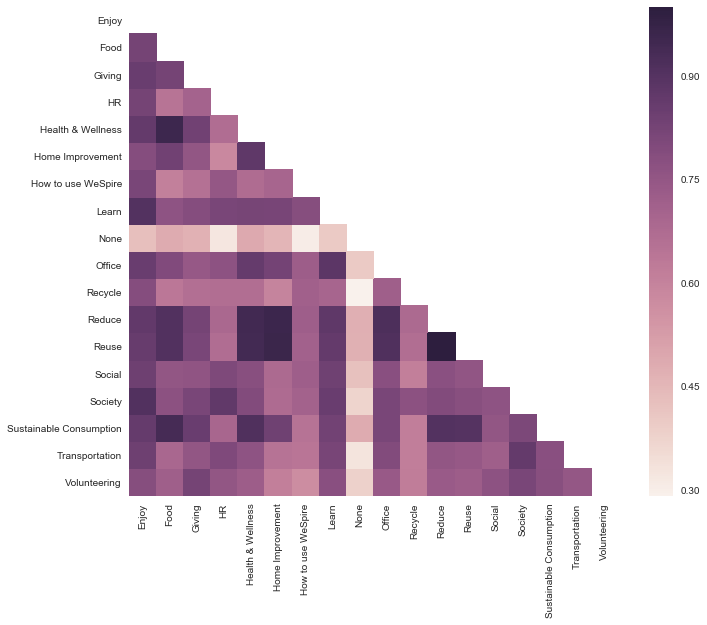

In [577]:
# get X and y from table
X, y = user_good_2.ix[:,'Enjoy':'Volunteering'], user_good_2.ix[:,'active']

y=pd.DataFrame(y, columns = ['active'])

corr = X.corr()

# Generate a mask for the upper triangle
sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
#            square=True, xticklabels=5, yticklabels=5,
#            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
sns.heatmap(corr, mask=mask, vmax=1.0, square=True)

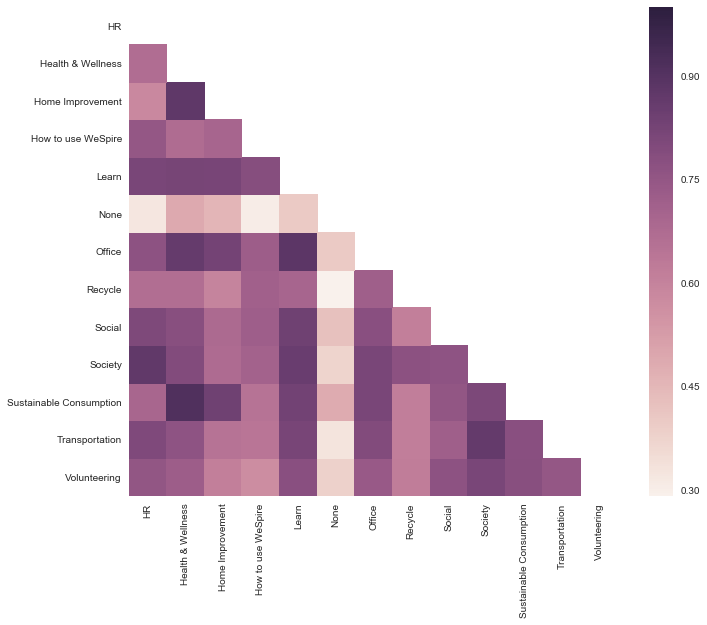

In [578]:
#Remove the highly correlated ones
user_good_decorr = user_good_2.drop(['Food', 'Reduce','Reuse','Enjoy','Giving'], axis=1)
#toCSV = user_good_decorr
#toCSV['user_id']=range(len(toCSV))
#toCSV.to_csv('toCSV.csv', index=False)

X_decorr, y = user_good_decorr.ix[:,'HR':'Volunteering'], user_good_decorr.ix[:,'active']
corr = X_decorr.corr()

# Generate a mask for the upper triangle
sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
#            square=True, xticklabels=5, yticklabels=5,
#            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
sns.heatmap(corr, mask=mask, vmax=1.0, square=True)

In [579]:
# under sampling active = 0 data
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler
#Under = RandomUnderSampler(random_state=45, replacement = False, ratio = 'auto')
#X_res, y_res= Under.fit_sample(X, y)

Over = RandomOverSampler(random_state=50, ratio = 'auto')
X_res, y_res= Over.fit_sample(X_decorr, y)
X_res = pd.DataFrame(X_res)
X_res.columns = list(X_decorr)

y_res = pd.DataFrame(y_res)

In [580]:
s = corr.unstack()
so = s.order(kind="quicksort")
#len(s)
so[len(so)-38:len(so)-17]
#so = s.order(kind="quicksort")

/Users/xixibest/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: order is deprecated, use sort_values(...)
  from ipykernel import kernelapp as app


Learn                    Home Improvement           0.819736
Health & Wellness        Learn                      0.820376
Learn                    Health & Wellness          0.820376
Office                   Home Improvement           0.828663
Home Improvement         Office                     0.828663
Learn                    Sustainable Consumption    0.832732
Sustainable Consumption  Learn                      0.832732
Home Improvement         Sustainable Consumption    0.838274
Sustainable Consumption  Home Improvement           0.838274
Learn                    Social                     0.841528
Social                   Learn                      0.841528
Learn                    Society                    0.854035
Society                  Learn                      0.854035
Health & Wellness        Office                     0.863623
Office                   Health & Wellness          0.863623
Transportation           Society                    0.868292
Society                 

In [581]:
#Run Logistic Regression on the balanced data
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=14)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20,random_state=15)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
X_train.info()
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4339 entries, 1945 to 3829
Data columns (total 13 columns):
HR                         4339 non-null float64
Health & Wellness          4339 non-null float64
Home Improvement           4339 non-null float64
How to use WeSpire         4339 non-null float64
Learn                      4339 non-null float64
None                       4339 non-null float64
Office                     4339 non-null float64
Recycle                    4339 non-null float64
Social                     4339 non-null float64
Society                    4339 non-null float64
Sustainable Consumption    4339 non-null float64
Transportation             4339 non-null float64
Volunteering               4339 non-null float64
dtypes: float64(13)
memory usage: 474.6 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085 entries, 3718 to 4937
Data columns (total 1 columns):
0    1085 non-null int64
dtypes: int64(1)
memory usage: 17.0 KB


In [582]:
X_train.max()

HR                           75.0
Health & Wellness           685.0
Home Improvement            614.0
How to use WeSpire           16.0
Learn                       190.0
None                       2628.0
Office                      206.0
Recycle                     128.0
Social                      555.0
Society                      84.0
Sustainable Consumption     208.0
Transportation               36.0
Volunteering                 72.0
dtype: float64

In [583]:
def roc_auc_score_proba(yy_true, pproba):
    return roc_auc_score(yy_true, pproba[:, 1])
auc_define = make_scorer(roc_auc_score_proba, needs_proba=True)

(-0.050000000000000003, 1.05, -0.048048327137546476, 1.049907063197026)

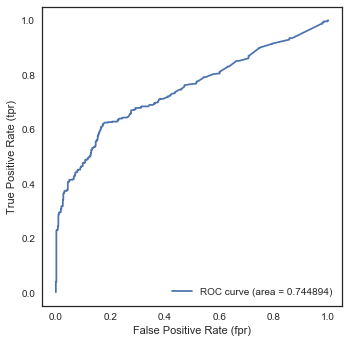

In [584]:
log_CV = LogisticRegressionCV(class_weight='balanced', cv=10, Cs = 100, 
                              penalty='l2', scoring=None, solver='lbfgs', refit = True,
                              dual=False)
logCV = log_CV.fit(X_train,y_train)


fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_logCV_prob[:,1])
roc_auc= auc(fpr, tpr)
roc_auc
plt.plot(fpr, tpr, label ='ROC curve (area = %f)'%roc_auc)
plt.xlabel('False Positive Rate (fpr)')
plt.ylabel('True Positive Rate (tpr)')
plt.legend(loc="lower right")
plt.axis('scaled')

In [585]:
np.where(np.around(tpr, 2)==0.6)

(array([190, 191, 192, 193]),)

In [646]:
threshold

array([ 1.        ,  1.        ,  1.        ,  1.        ,  0.99999999,
        0.99999999,  0.99999998,  0.99999998,  0.99999996,  0.99999992,
        0.9999999 ,  0.99999984,  0.99999979,  0.99999973,  0.99999966,
        0.99999891,  0.99999795,  0.99999456,  0.99999406,  0.99997948,
        0.99995713,  0.99995425,  0.99985949,  0.9998008 ,  0.99977781,
        0.99975996,  0.99973599,  0.99956133,  0.99935754,  0.99892142,
        0.9989    ,  0.99882343,  0.99854808,  0.99850884,  0.99844159,
        0.99839679,  0.99828791,  0.99823596,  0.9982348 ,  0.99642802,
        0.99579902,  0.99283664,  0.99139694,  0.99123682,  0.99012752,
        0.98969984,  0.98093643,  0.97901341,  0.9775948 ,  0.97623308,
        0.97205168,  0.96766436,  0.96509557,  0.9604024 ,  0.95835665,
        0.95768839,  0.94894253,  0.94476037,  0.94019502,  0.93041196,
        0.93000116,  0.91775046,  0.91571661,  0.90686397,  0.90534301,
        0.8992105 ,  0.89478294,  0.89467221,  0.8940568 ,  0.89

In [674]:
y_pred_logCV_prob = logCV.predict_proba(X_test)
y_pred_logCV = np.where(y_pred_logCV_prob[:,1] > 0.44, 1, 0)

In [675]:
logCV.C_

array([ 0.14174742])

In [676]:
metrics.confusion_matrix(y_test, y_pred_logCV)

array([[459,  88],
       [218, 320]])

In [677]:
metrics.accuracy_score(y_test, y_pred_logCV)

0.71797235023041472

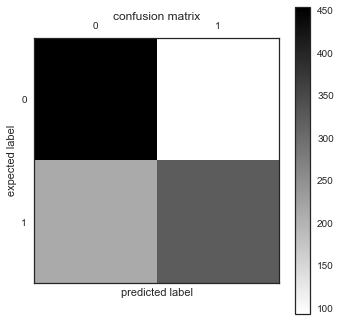

In [590]:
plt.matshow(metrics.confusion_matrix(y_test, y_pred_logCV), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()

In [591]:
metrics.precision_score(y_test, y_pred_logCV)

0.7769784172661871

In [592]:
metrics.recall_score(y_test, y_pred_logCV)

0.60223048327137552

In [593]:
metrics.accuracy_score(y_test, y_pred_logCV)

0.71705069124423959

In [594]:
metrics.f1_score(y_test, y_pred_logCV)

0.67853403141361268

In [595]:
coef = (logCV.coef_).transpose()
#coef = (logCV.coef_* DataRange).transpose()
coef = pd.DataFrame(coef)
coef.columns = ['Feature_Coefficient']
coef['Feature'] = list(X_train)
coef = coef.sort_values(by='Feature_Coefficient')
coef.set_index('Feature',inplace=True,drop=False)
coef

,Feature_Coefficient,Feature
Feature,,
Transportation,-0.294248,Transportation
HR,-0.233043,HR
Society,-0.161561,Society
Sustainable Consumption,-0.072950,Sustainable Consumption
Learn,-0.052527,Learn
Recycle,-0.036811,Recycle
Office,-0.018824,Office
Home Improvement,0.001997,Home Improvement
None,0.007559,None


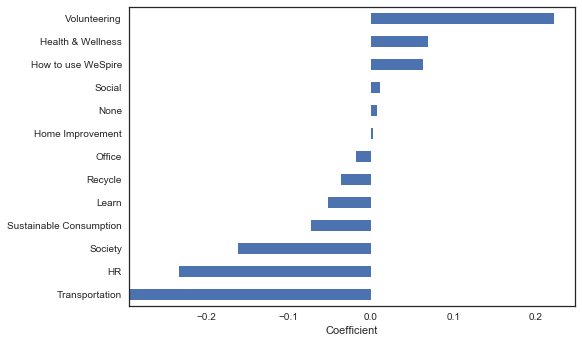

In [596]:
ax = coef.plot(kind='barh',use_index=True)
ax.set_yticklabels(coef.Feature)
ax.legend(['coefficient'])
ax.legend_.remove()
ax.set_xlabel('Coefficient')
ax.set_ylabel('')
#ax.set_xlim(-0.01,0.5)